In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from boruta import BorutaPy
from numpy import ndarray
from pyexpat import features
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [9]:
def generate_data(n,p,k,scheme="one"):
    def scheme_one():
        y=np.zeros(n)
        X=np.zeros((n,p))
        for i in range(n):
            x=np.random.normal(0,1,p)
            X[i,:]=x
            th=stats.chi2.ppf(0.5,df=k)
            y[i]=1 if np.sum(x[0:k]**2)>th else 0
        return X,y
    def scheme_two():
        y=np.zeros(n)
        X=np.zeros((n,p))
        for i in range(n):
            x=np.random.normal(0,1,p)
            X[i,:]=x
            
            y[i]=1 if np.sum(np.abs(x[0:k]))>k else 0
        return X,y
    if scheme=="one":
        return scheme_one()
    else:
        return scheme_two()
        

In [5]:
class VarImportanceRanker:
    def __init__(self,X:np.ndarray,y:np.ndarray,rf_args:dict={}):
        self.X:np.ndarray=X
        self.y:np.ndarray=y
        self.rf:RandomForestClassifier=RandomForestClassifier(**rf_args)
        self.boruta:BorutaPy=BorutaPy(RandomForestClassifier(**rf_args))
    def _impurity_rf(self):
        self.rf.fit(self.X,self.y)
        return self.rf.feature_importances_
    def _boruta(self):
        self.boruta.fit(self.X,self.y)
        return self.boruta.ranking_
    def _feat_perm(self):
        self.rf.fit(self.X,self.y)
        res=permutation_importance(self.rf,self.X,self.y)
        return res.importances_mean
    def rank(self,name="boruta"):
        if name=="impurity":
            return self._impurity_rf()
        if name=="feat_perm":
            return self._feat_perm()
        if name=="boruta":
            return self._boruta()
        raise NotImplemented
    
    
        

In [6]:
def check_corectness(N,P_K,length,methods,L=25):
    counters={}
    for m in methods:
        counters[m]=0
    for i in range(L):
        i=np.random.randint(length)
        X,y=generate_data(N[i],P_K[i][0],P_K[i][1],scheme="one")
        k=P_K[i][1]
        correct={np.int64(j) for j in range(k)}
        ranker=VarImportanceRanker(X,y)
        for m in methods:
            ranked=np.argsort(ranker.rank(m))
            if m!="boruta":
                ranked=ranked[::-1]
            ranked=set(ranked[:k])
            if ranked==correct:
                counters[m]+=1
        
    for m in methods:
        counters[m]=counters[m]/L
        plt.bar(m,counters[m])
    plt.show()

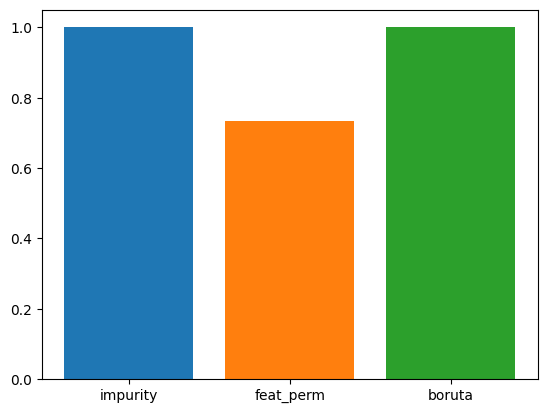

In [62]:
N=[200,300,400,500]
P_K=[(10,2),(20,4),(25,5),(50,10)]
methods=["impurity","feat_perm","boruta"]
check_corectness(N,P_K,4,methods,L=15)

In [7]:
from sklearn.metrics import accuracy_score
def size_experiment_training(methods,n,p,k,T,sheme="one"):
    X,y=generate_data(n,p,k,scheme=sheme)
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
    scores={}
    accuracies={}
    ranker=VarImportanceRanker(X_train,y_train)
    plt.figure(figsize=(10,6))
    for m in methods:
        ranked=np.argsort(ranker.rank(m))
        accuracies[m]=[]
        if m!="boruta":
            ranked=ranked[::-1]
        
        scores[m]=ranked
        for t in T:
            features_idx=ranked[:t]
            rf=RandomForestClassifier().fit(X_train[:,features_idx],y_train)
            y_hat=rf.predict(X_test[:,features_idx])
            accuracies[m].append(accuracy_score(y_test,y_hat))
    
        plt.plot(T,accuracies[m],label=m)
    plt.legend()
    plt.show()
    

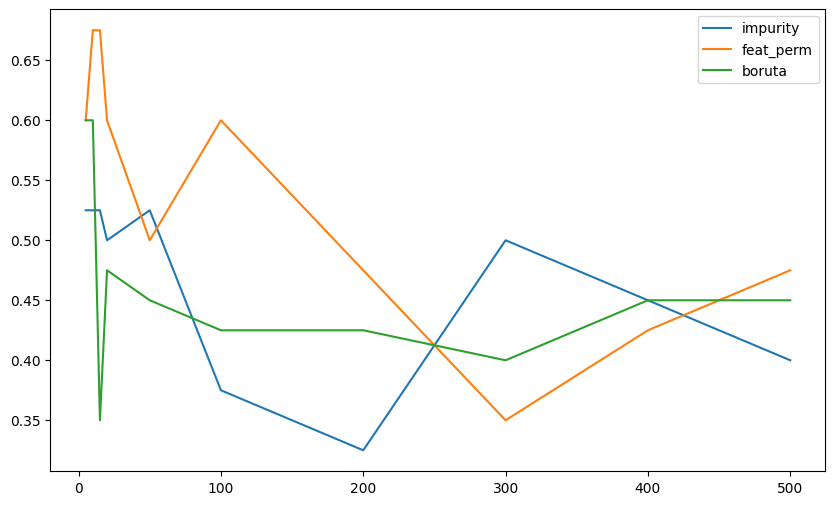

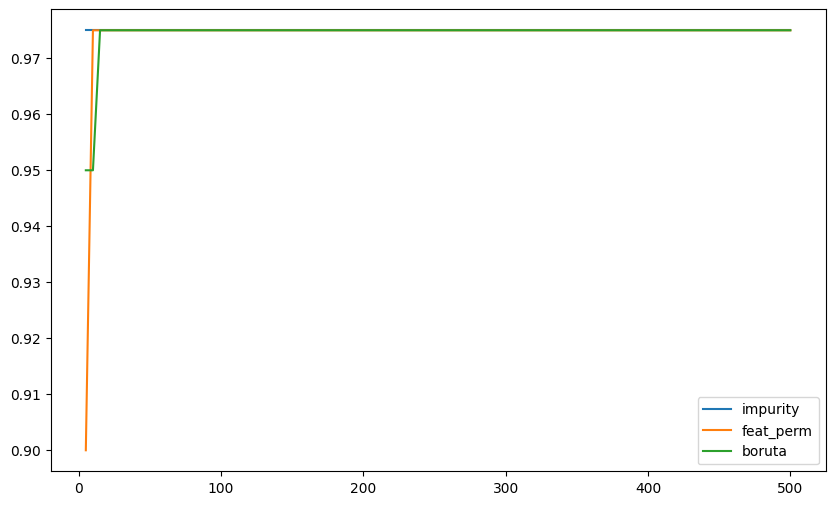

In [10]:
n=200
p=500
k=20
methods=["impurity","feat_perm","boruta"]
T=[5,10,15,20,50,100,200,300,400,500]
size_experiment_training(methods,n,p,k,T)
size_experiment_training(methods,n,p,k,T,"two")

In [11]:
X,y=generate_data(100,10,2,"two")

In [13]:
X

array([[ 5.19513178e-01, -9.40242176e-01,  5.25260307e-01,
         1.10716899e+00, -4.61845614e-01,  5.26304967e-01,
        -1.12235675e-01, -3.85968493e-01, -3.91231930e-01,
        -1.18220900e+00],
       [ 3.73406648e-01, -9.98818095e-01, -4.32256258e-01,
        -2.72098000e-01,  9.88548495e-01,  1.25256670e+00,
        -3.08837932e-01, -4.55391273e-01, -9.94235637e-01,
         5.29181624e-01],
       [-9.83458531e-02,  4.83875759e-01,  7.87559714e-01,
         2.31460176e+00, -2.53369303e-01,  6.33619070e-01,
         9.10637321e-01, -2.88685406e-01,  2.06224761e+00,
        -5.03813535e-01],
       [ 1.33634617e+00, -4.94649466e-01, -1.12333661e-01,
         2.80557354e-01,  6.60416309e-01, -5.00072296e-02,
         2.65068440e-01, -8.60530157e-01,  2.06453859e+00,
         2.52770566e-01],
       [ 3.89351208e-03,  1.17856613e+00, -1.70500316e+00,
        -1.27694174e+00,  1.99541253e-01,  1.04356344e+00,
         3.75261102e-01, -6.04158765e-01, -6.41963648e-01,
         1.